# Loading Data

In [1]:
import pandas as pd
from plotnine import *
from plotnine.data import *
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
import numpy as np

pd.reset_option('^display.', silent=True)

df = pd.DataFrame()


def readDF(source,name,fname):
    df = pd.read_csv('data/tuningData/' + fname)
    df['dataset']=name
    df['datasource']=source
    df['isInterstingStrict'] = (df['interestingnessEvidence']>0) & (df['hasChangeAfterTrainPeriod'])
    df['isInterstingStrictOneTimeUnit'] = (df['interestingnessEvidenceOneTimeUnitAfterTrain']>0) & (df['isInterestingOneTimeUnitAfterTrain'])
    return df


#wikipedia:
dfPolitics = readDF('wikipedia','politics','politics_stats.csv')
dfMilitary = readDF('wikipedia','military','military_stats.csv')
dfFootball = readDF('wikipedia','football','football_stats.csv')
dfTV = readDF('wikipedia','tv_and_film','tv_and_film_stats.csv')
dfEducation = readDF('wikipedia','education','education_stats.csv')
#dfMusic = readDF('wikipedia','music','music_stats.csv')
#socrata
dfAustin = readDF('socrata','austintexas','austintexas_stats.csv')
dfChicago = readDF('socrata','chicago','chicago_stats.csv')
dfMaryland = readDF('socrata','gov.maryland','gov.maryland_stats.csv')
dfOregon = readDF('socrata','oregon','oregon_stats.csv')
dfUtah = readDF('socrata','utah','utah_stats.csv')
print(dfUtah.columns)



Index(['Vertex1ID', 'Vertex2ID', 'trainEndDate', 'remainsValidFullTimeSpan',
       'hasChangeAfterTrainPeriod', 'interestingnessEvidence',
       'evalEndDateOneTimeUnitAfterTrain', 'remainsValidOneTimeUnitAfterTrain',
       'isInterestingOneTimeUnitAfterTrain',
       'interestingnessEvidenceOneTimeUnitAfterTrain', 'strongPositive_count',
       'weakPositive_count', 'neutral_count', 'weakNegative_count',
       'strongNegative_count', 'strongPositive_scoreSum',
       'weakPositive_scoreSum', 'neutral_scoreSum', 'weakNegative_scoreSum',
       'strongNegative_scoreSum', 'dataset', 'datasource',
       'isInterstingStrict', 'isInterstingStrictOneTimeUnit'],
      dtype='object')


In [2]:
#organize dataframes:
allDfsSocrata=[dfAustin,dfChicago,dfMaryland,dfOregon,dfUtah]
allDfsWikipedia=[dfPolitics,dfMilitary,dfFootball,dfTV,dfEducation] #dfMusic
allDfs = allDfsSocrata+allDfsWikipedia
#df = dfPolitics.append(dfMilitary).append(dfAustin).append(dfChicago).append(dfMaryland).append(dfOregon).append(dfUtah)#.append(dfFootball)

# General Statistics

In [3]:
def printDFInfo(curDf,rowList):
    print("----------------------------------------------------------------------------------------")
    print(curDf['dataset'].iloc[0],curDf['trainEndDate'].iloc[0])
    validRowsStrictFull = curDf[curDf['remainsValidFullTimeSpan']]
    isInterstingStrictFull = curDf[curDf['isInterstingStrict']]
    validRelFrequencyFull=len(validRowsStrictFull.index)/len(curDf.index)
    #print("Total Row Count is", len(curDf.index), "of which ",len(validRowsStrictFull.index),"are valid (strict) in FUll time period - ",100*validRelFrequencyFull,"%"  )
    canBeEvaluatedRelFrequencyFull=len(isInterstingStrictFull.index)/len(curDf.index)
    #print("Total Row Count is", len(curDf.index), "of which ",len(isInterstingStrictFull.index),"are interesting (new) in FUll time period",100*canBeEvaluatedRelFrequencyFull,"%"  )
    
    curDf['isInterstingStrictOneTimeUnit'] = (curDf['interestingnessEvidenceOneTimeUnitAfterTrain']>0) & (curDf['isInterestingOneTimeUnitAfterTrain'])
    validRowsStrictOneTimeUnit = curDf[curDf['remainsValidOneTimeUnitAfterTrain']]
    isInterstingStrictOneTimeUnit = curDf[curDf['isInterstingStrictOneTimeUnit']]
    validRelFrequencyOneTimeUnit=len(validRowsStrictOneTimeUnit.index)/len(curDf.index)
    #print("Total Row Count is", len(curDf.index), "of which ",len(validRowsStrictOneTimeUnit.index),"are valid (strict) in ONE time period after train ",100*validRelFrequencyOneTimeUnit,"%"  )
    canBeEvaluatedRelFrequencyOneTimeUnitAfter=len(isInterstingStrictOneTimeUnit.index)/len(curDf.index)
    #print("Total Row Count is", len(curDf.index), "of which ",len(isInterstingStrictOneTimeUnit.index),"are interesting (new) in ONE time period after train",100*canBeEvaluatedRelFrequencyOneTimeUnitAfter,"%"  )
    
    validRowsOfInterestingFull = isInterstingStrictFull[isInterstingStrictFull['remainsValidFullTimeSpan']]
    validRowsOfInterestingOneTimeUnitAfter = isInterstingStrictOneTimeUnit[isInterstingStrictOneTimeUnit['remainsValidOneTimeUnitAfterTrain']]
    if(len(isInterstingStrictFull.index)==0):
        validRelFrequencyFullOfInteresting=np.NAN
    else:
        validRelFrequencyFullOfInteresting=len(validRowsOfInterestingFull.index)/len(isInterstingStrictFull.index)
    if(len(isInterstingStrictOneTimeUnit.index)==0):
        validRelFrequencyOneTimeUnitAfterInteresting=np.NAN
    else:
        validRelFrequencyOneTimeUnitAfterInteresting=len(validRowsOfInterestingOneTimeUnitAfter.index)/len(isInterstingStrictOneTimeUnit.index)
    
    #print("Total Interesting Edge Count is",len(isInterstingStrictFull.index),"of which ",len(validRowsOfInterestingFull.index),"are valid in FULL Time Period (",100*validRelFrequencyFullOfInteresting,"%)")
    #print("Total Interesting Edge Count is",len(validRowsOfInterestingOneTimeUnitAfter.index),"of which ",len(isInterstingStrictOneTimeUnit.index),"are valid in ONE Time Period after (",100*validRelFrequencyOneTimeUnitAfterInteresting,"%)")
    dict1 = {"dataset": curDf['dataset'].iloc[0], 
                     "trainEndDate": curDf['trainEndDate'].iloc[0],
                     "nEdges":len(curDf.index),
                     "validPercentageFullTimePeriod":validRelFrequencyFull,
                     "validPercentageFullTimePeriodOfInteresting":validRelFrequencyFullOfInteresting,
                     "canBeEvaluatedPercentageFullTimePeriod":canBeEvaluatedRelFrequencyFull,
                     "validPercentageOneTimeUnit":validRelFrequencyOneTimeUnit,
                     "validPercentageOneTimeUnitOfInteresting":validRelFrequencyOneTimeUnitAfterInteresting,
                     "canBeEvaluatedPercentageOneTimeUnit":canBeEvaluatedRelFrequencyOneTimeUnitAfter,
            }
    rowList.append(dict1)
    
def processDFList(dfs):    
    rowList=[]
    for df in dfs:
        byTrainTimeEnd = df.groupby('trainEndDate')    
        subDFs = [byTrainTimeEnd.get_group(x) for x in byTrainTimeEnd.groups]
        for subDF in subDFs:
            printDFInfo(subDF,rowList)
    toReturn=pd.DataFrame(rowList)
    return toReturn
    
aggregateStatSocrataDF=processDFList(allDfsSocrata)
aggregateStatWikipediaDF=processDFList(allDfsWikipedia)
print(aggregateStatSocrataDF)
print(aggregateStatWikipediaDF)

----------------------------------------------------------------------------------------
austintexas 2020-04-30
----------------------------------------------------------------------------------------
austintexas 2020-05-31
----------------------------------------------------------------------------------------
austintexas 2020-06-30


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
austintexas 2020-07-31
----------------------------------------------------------------------------------------
austintexas 2020-08-31
----------------------------------------------------------------------------------------
austintexas 2020-09-30
----------------------------------------------------------------------------------------
austintexas 2020-10-31


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:

----------------------------------------------------------------------------------------
chicago 2020-04-30
----------------------------------------------------------------------------------------
chicago 2020-05-31
----------------------------------------------------------------------------------------
chicago 2020-06-30
----------------------------------------------------------------------------------------
chicago 2020-07-31
----------------------------------------------------------------------------------------
chicago 2020-08-31
----------------------------------------------------------------------------------------
chicago 2020-09-30
----------------------------------------------------------------------------------------
chicago 2020-10-31


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:

----------------------------------------------------------------------------------------
gov.maryland 2020-04-30
----------------------------------------------------------------------------------------
gov.maryland 2020-05-31
----------------------------------------------------------------------------------------
gov.maryland 2020-06-30
----------------------------------------------------------------------------------------
gov.maryland 2020-07-31
----------------------------------------------------------------------------------------
gov.maryland 2020-08-31
----------------------------------------------------------------------------------------
gov.maryland 2020-09-30
----------------------------------------------------------------------------------------
gov.maryland 2020-10-31
----------------------------------------------------------------------------------------
oregon 2020-04-30
----------------------------------------------------------------------------------------
oregon 2020-0

<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:

----------------------------------------------------------------------------------------
oregon 2020-06-30
----------------------------------------------------------------------------------------
oregon 2020-07-31
----------------------------------------------------------------------------------------
oregon 2020-08-31
----------------------------------------------------------------------------------------
oregon 2020-09-30
----------------------------------------------------------------------------------------
oregon 2020-10-31


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:

----------------------------------------------------------------------------------------
utah 2020-04-30
----------------------------------------------------------------------------------------
utah 2020-05-31


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
utah 2020-06-30
----------------------------------------------------------------------------------------
utah 2020-07-31
----------------------------------------------------------------------------------------
utah 2020-08-31


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
utah 2020-09-30
----------------------------------------------------------------------------------------
utah 2020-10-31


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
politics 2011-05-07
----------------------------------------------------------------------------------------
politics 2012-05-05


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
politics 2013-05-04
----------------------------------------------------------------------------------------
politics 2014-05-03
----------------------------------------------------------------------------------------
politics 2015-05-02


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
politics 2016-04-30
----------------------------------------------------------------------------------------
politics 2017-04-29
----------------------------------------------------------------------------------------
politics 2018-04-28


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
military 2011-05-07


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
military 2012-05-05
----------------------------------------------------------------------------------------
military 2013-05-04


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
military 2014-05-03
----------------------------------------------------------------------------------------
military 2015-05-02


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
military 2016-04-30
----------------------------------------------------------------------------------------
military 2017-04-29


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
military 2018-04-28


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
football 2011-05-07


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
football 2012-05-05
----------------------------------------------------------------------------------------
football 2013-05-04


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
football 2014-05-03
----------------------------------------------------------------------------------------
football 2015-05-02


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
football 2016-04-30
----------------------------------------------------------------------------------------
football 2017-04-29


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
football 2018-04-28


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
tv_and_film 2011-05-07


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
tv_and_film 2012-05-05


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
tv_and_film 2013-05-04
----------------------------------------------------------------------------------------
tv_and_film 2014-05-03


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
tv_and_film 2015-05-02
----------------------------------------------------------------------------------------
tv_and_film 2016-04-30


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
tv_and_film 2017-04-29
----------------------------------------------------------------------------------------
tv_and_film 2018-04-28


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
education 2011-05-07
----------------------------------------------------------------------------------------
education 2012-05-05


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
education 2013-05-04
----------------------------------------------------------------------------------------
education 2014-05-03


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
education 2015-05-02
----------------------------------------------------------------------------------------
education 2016-04-30


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----------------------------------------------------------------------------------------
education 2017-04-29
----------------------------------------------------------------------------------------
education 2018-04-28


<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-3-98b0b7450f85>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


         dataset trainEndDate  nEdges  validPercentageFullTimePeriod  \
0    austintexas   2020-04-30  417199                       0.438781   
1    austintexas   2020-05-31  378024                       0.484252   
2    austintexas   2020-06-30  300190                       0.609810   
3    austintexas   2020-07-31  223637                       0.818554   
4    austintexas   2020-08-31  214450                       0.853621   
5    austintexas   2020-09-30  201189                       0.909886   
6    austintexas   2020-10-31  183059                       1.000000   
7        chicago   2020-04-30  191798                       0.273402   
8        chicago   2020-05-31  132238                       0.396543   
9        chicago   2020-06-30   91665                       0.572061   
10       chicago   2020-07-31   73185                       0.716513   
11       chicago   2020-08-31   62101                       0.844399   
12       chicago   2020-09-30   55773                       0.94

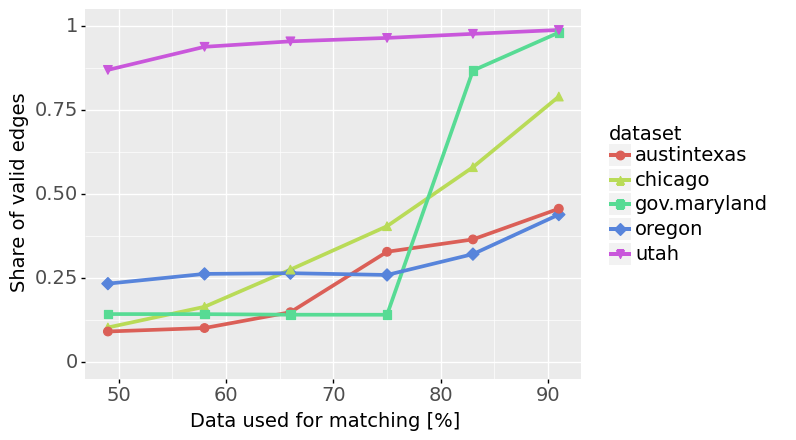

/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/validityOverMatchingTime_socrata.jpg


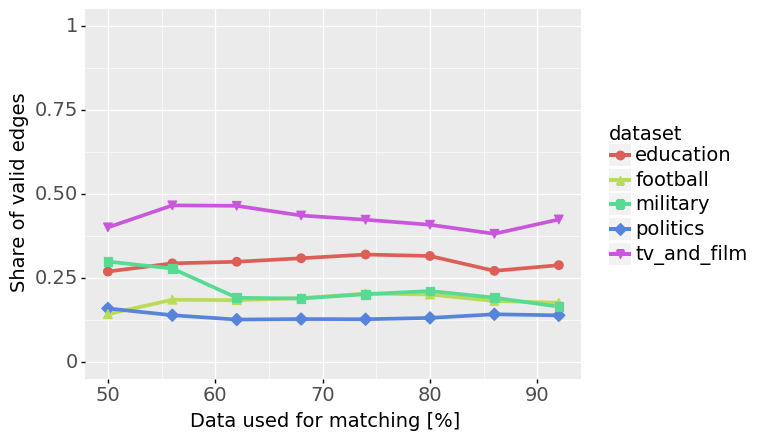

/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/validityOverMatchingTime_wikipedia.jpg


In [49]:
dateToPercentageSocrata = {
    '2020-04-30' : 49,
    '2020-05-31' : 58,
    '2020-06-30' : 66,
    '2020-07-31' : 75,
    '2020-08-31' : 83,
    '2020-09-30' : 91
}
dateToPercentageWikipedia = {
'2011-05-07' : 50,
'2012-05-05' : 56,
'2013-05-04' : 62,
'2014-05-03' : 68,
'2015-05-02' : 74,
'2016-04-30' : 80,
'2017-04-29' : 86,
'2018-04-28' : 92, 
}

#TODO: map dates to percentages!
aggregateStatSocrataDF=aggregateStatSocrataDF[aggregateStatSocrataDF['trainEndDate'] != '2020-10-31']
aggregateStatSocrataDF["matchingTimePercentage"] = list(map(lambda x : dateToPercentageSocrata[x],list(aggregateStatSocrataDF['trainEndDate'])))
aggregateStatWikipediaDF["matchingTimePercentage"] = list(map(lambda x : dateToPercentageWikipedia[x],list(aggregateStatWikipediaDF['trainEndDate'])))

def printPlots(df,datasource):
    #print(ggplot(df, aes(x='trainEndDate',ymin=0,ymax=1, y='nEdges',group='dataset',color='dataset')) 
    #  + geom_line() 
    #  + theme(axis_text_x=element_text(rotation=45, hjust=1))
    #  + labs(title='Edge Count by trainTimeEnd')) 

   # print(ggplot(df, aes(x='trainEndDate',ymin=0,ymax=1, y='validPercentageFullTimePeriod',group='dataset',color='dataset')) 
      #+ geom_line() 
     # + theme(axis_text_x=element_text(rotation=45, hjust=1))
    #  + labs(title='Validity (FULL TIME PERIOD) by trainTimeEnd')) 

    #print(ggplot(df, aes(x='trainEndDate',ymin=0,ymax=1, y='canBeEvaluatedPercentageFullTimePeriod',group='dataset',color='dataset')) 
   #   + geom_line() 
   #   + theme(axis_text_x=element_text(rotation=45, hjust=1))
   #   + labs(title='Interestingness (FULL TIME PERIOD) by trainTimeEnd')) 
    
   # print(ggplot(df, aes(x='trainEndDate',ymin=0,ymax=1, y='validPercentageOneTimeUnit',group='dataset',color='dataset')) 
   #   + geom_line() 
   #   + theme(axis_text_x=element_text(rotation=45, hjust=1))
   #   + labs(title='Validity (ONE TIME UNIT AFTER) by trainTimeEnd')) 

    #print(ggplot(df, aes(x='trainEndDate',ymin=0,ymax=1, y='canBeEvaluatedPercentageOneTimeUnit',group='dataset',color='dataset')) 
    #  + geom_line() 
    #  + theme(axis_text_x=element_text(rotation=45, hjust=1))
    #  + labs(title='Interestingness (ONE TIME UNIT AFTER) by trainTimeEnd')) 
        
    plot = (ggplot(df, aes(x='matchingTimePercentage',ymin=0,ymax=1, y='validPercentageFullTimePeriodOfInteresting',group='dataset',color='dataset',shape='dataset')) 
      + geom_line(size=1.5) 
      + geom_point(size=3)
      + scale_x_continuous(name="Data used for matching [%]")
      + scale_y_continuous(name="Share of valid edges")
      + theme(text=element_text(size=14))
      #+ theme(axis_text_x=element_text(size=12),axis_text_y=element_text(size=12))
      + labs(title=''))
    print(plot)
    fname = 'exportedPlots/validityOverMatchingTime_' + datasource +'.jpg'
    plot.save(filename = fname)
    
    #print(ggplot(df, aes(x='matchingTimePercentage',ymin=0,ymax=1, y='validPercentageOneTimeUnitOfInteresting',group='dataset',color='dataset')) 
    #  + geom_line()
    #  + scale_x_continuous(name="Matching Time [%]")
    #  + scale_y_continuous(name="Validity")
    #  + theme(text=element_text(size=14))
    #  #+ theme(axis_text_x=element_text(size=7),axis_text_y=element_text(size=12))
    #  + labs(title='Validity (ONE TIME UNIT AFTER) by trainTimeEnd (Only Intersting)')) 
    
printPlots(aggregateStatSocrataDF,"socrata")
printPlots(aggregateStatWikipediaDF,"wikipedia")

# Tuning

In [5]:
#Filters:
#dfFiltered=df[df['trainEndDate']=='2011-05-07']
#dfFiltered=df[((df['trainEndDate']=='2011-05-07') | (df['trainEndDate']=='2020-04-30')) & df['isInterstingStrict']]
#dfFiltered=df[df['isInterstingStrict']]
#print(dfFiltered)
#dfWiki=dfWiki[dfWiki['isInterstingStrict']]
#dfSocrata=df[df['trainEndDate']=='2020-04-30']
#dfSocrata=dfSocrata[dfSocrata['isInterstingStrict']]

def filterDF(df):
    return df[((df['trainEndDate']=='2011-05-07') | (df['trainEndDate']=='2020-04-30')) & df['isInterstingStrict']]

allDfsFiltered = list(map(filterDF,allDfs))
print(allDfsFiltered)

[                                                 Vertex1ID  \
0        gov.austintexas_gov.austintexas.x5p7-qyuv.0_61...   
12       gov.austintexas_gov.austintexas.b4k4-adkb.0_21...   
27        gov.austintexas_gov.austintexas.98zg-jkqu.0_2_33   
41       gov.austintexas_gov.austintexas.i26j-ai4z.0_18...   
48       gov.austintexas_gov.austintexas.ttd7-isgm.0_27...   
...                                                    ...   
1917733  gov.austintexas_gov.austintexas.3syk-w9eu.0_23_42   
1917739  gov.austintexas_gov.austintexas.3syk-w9eu.0_23_42   
1917745  gov.austintexas_gov.austintexas.v7zg-5jg9.0_10...   
1917746  gov.austintexas_gov.austintexas.v7zg-5jg9.0_10...   
1917747  gov.austintexas_gov.austintexas.v7zg-5jg9.0_10...   

                                                 Vertex2ID trainEndDate  \
0        gov.austintexas_gov.austintexas.x5p7-qyuv.0_8_290   2020-04-30   
12       gov.austintexas_gov.austintexas.p53x-x73x.0_25...   2020-04-30   
27       gov.austintexas_gov.

In [47]:


y_test = [False,True,False,False,True,False,True,True]
y_pred = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
precision, recall, thresholds = precision_recall_curve(y_test,y_pred)

indices = (precision !=0) | (recall!=0)
precision = precision[indices]
recall = recall[indices]
#thresholds = thresholds[indices[0:len(indices)-1]]

ranges = getRangeForThreshold(thresholds)

f1_scores = 2*recall*precision/(recall+precision)
f1_scores=f1_scores[0:len(f1_scores)-1]

#print(precision)
print("recall:",np.array(recall))
print(thresholds)
print(np.array(ranges))
#print(f1_scores)

#Threshold[i] means take everything LARGER than that THRESHOLD

recall: [1.   0.75 0.75 0.75 0.5  0.5  0.25 0.  ]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[0.1 0.1 0.1 0.1 0.1 0.1 0. ]


In [6]:
from random import random

numTransitionsTotalWikipedia=435 #train + test: 869
numTransitionsTotalSocrata=182 #train + test: 364

def createScore(weights,dfFiltered):
    #weightsRelative = [weights[0]/numTransitionsTotal,weights[1]/numTransitionsTotal,weights[2],weights[3]/numTransitionsTotal,weights[4]/numTransitionsTotal]
    totalCount = np.where(dfFiltered['datasource']== 'wikipedia', 869, 364)
    scoreVector=((dfFiltered['strongPositive_scoreSum']/totalCount)*weights[0] + 
                        (dfFiltered['weakPositive_scoreSum']/totalCount)*weights[1] +
                        (dfFiltered['neutral_scoreSum']/totalCount)*weights[2] +
                        (dfFiltered['weakNegative_scoreSum']/totalCount)*weights[3] +
                        (dfFiltered['strongNegative_scoreSum']/totalCount)*weights[4])
    return scoreVector

def getRangeForThreshold(thresholds):
    ranges = []
    for i in range(len(thresholds)):
        if(i<len(thresholds)-1):
            ranges.append(thresholds[i+1]-thresholds[i])
        else:
            ranges.append(0)
    return np.array(ranges)

def appendF1DFEntry(dfForThisDsAndScore,rows_listF1,scoreName,y_pred,truthLabel,curWeights,curRatio):
    dsName=dfForThisDsAndScore['dataset'].iloc[0]
    #dfForThisDsAndScore = dfForThisDs[dfForThisDs[predScore].notnull()]
    y_test = dfForThisDsAndScore[truthLabel]
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
    indices = (precision !=0) | (recall!=0)
    precision = precision[indices]
    recall = recall[indices]
    thresholds = thresholds[indices[0:len(indices)-1]]
    ranges = getRangeForThreshold(thresholds)
    f1_scores = 2*recall*precision/(recall+precision)
    f1_scores=f1_scores[0:len(f1_scores)-1]
    bestThresholdIndex=np.argmax(f1_scores)
    precision=precision[0:len(precision)-1]
    recall=recall[0:len(recall)-1]
    thisRange = ranges[bestThresholdIndex]
    maxRange = np.max(ranges)
    avgRange = np.mean(ranges)
    dict1 = {"dataset": dsName, 
             "scoreName": scoreName, 
             "bestThreshold": thresholds[bestThresholdIndex],
             "best_F1":f1_scores[bestThresholdIndex],#np.max(f1_scores),
             "precision":precision[bestThresholdIndex],
             "recall":recall[bestThresholdIndex],
             "strongPositiveWeight":curWeights[0],
             "weakPositiveWeight":curWeights[1],
             "neutralWeight":curWeights[2],
             "weakNegativeWeight":curWeights[3],
             "strongNegativeWeight":curWeights[4],
             "pr":curRatio['pr'],
             "nr":curRatio['nr'],
             "nTOp":curRatio['nTOp'],
             "ThresholdRange":thisRange,
             "ThresholdRangeMax":maxRange,
             "ThresholdRangeAvg":avgRange
            }
    rows_listF1.append(dict1)
    
ratiosToTest = [1.0,0.8,0.6,0.4,0.2,0.1,0.01,0.001,0.0001]
ratiosNegativeToPositive = [100.0,10.0,5.0,1.0,0.5,0.1,0.01]
scoreNames=[]
allWeights={}
allRatios={}



rows_listF1 = []
for curDF in allDfsFiltered:
    dsName=curDF['dataset'].iloc[0]
    print("Processing",dsName)
    for positiveRatio in ratiosToTest:
        for negativeRatio in ratiosToTest:
            for negativeToPositiveRatio in ratiosNegativeToPositive:
                if(negativeToPositiveRatio<=1):
                    weights = [1.0,positiveRatio*1.0,0,-negativeRatio*1.0*negativeToPositiveRatio,-1.0*negativeToPositiveRatio]
                    scoreName="score_pr:"+str(positiveRatio) + "_nr:" + str(negativeRatio) + "_nTOp:"+str(negativeToPositiveRatio)
                else:
                    positiveToNegativeRatio = 1/negativeToPositiveRatio
                    weights = [1.0*positiveToNegativeRatio,positiveToNegativeRatio*positiveRatio*1.0,0,-negativeRatio*1.0,-1.0]
                    scoreName="score_pr:"+str(positiveRatio) + "_nr:" + str(negativeRatio) + "_pTOn:"+str(positiveToNegativeRatio)
                allWeights[scoreName]=weights
                curRatio = {'pr':positiveRatio,'nr':negativeRatio,'nTOp':negativeToPositiveRatio}
                allRatios[scoreName]=curRatio
                scoreNames.append(scoreName)
                #print(weights)
                scoreVector = createScore(weights,curDF)
                #appendF1DFEntry(dfForThisDsAndScore,rows_listF1,scoreName,y_pred,truthLabel,curWeights,curRatio):
                appendF1DFEntry(curDF,rows_listF1,scoreName,scoreVector,'remainsValidFullTimeSpan',weights,curRatio)
                #With not all data: appendF1DFEntry(curDF,rows_listF1,scoreName,scoreVector,'remainsValidOneTimeUnitAfterTrain',weights,curRatio)

dfF1 = pd.DataFrame(rows_listF1)
                
print(len(allRatios))
print(len(allWeights))
print(len(scoreNames))
#print(len(dfFiltered.columns))
#print(len(dfFiltered))

dfF1.sort_values(by=['best_F1'],inplace=True)
print(dfF1)


Processing austintexas
Processing chicago
Processing gov.maryland
Processing oregon
Processing utah
Processing politics
Processing military
Processing football
Processing tv_and_film
Processing education
567
567
5670
           dataset                         scoreName  bestThreshold   best_F1  \
1253  gov.maryland  score_pr:0.8_nr:0.0001_pTOn:0.01      -0.321428  0.250659   
1193  gov.maryland   score_pr:1.0_nr:0.0001_nTOp:1.0      -0.321387  0.250659   
1192  gov.maryland   score_pr:1.0_nr:0.0001_pTOn:0.2      -0.321420  0.250659   
1191  gov.maryland   score_pr:1.0_nr:0.0001_pTOn:0.1      -0.321424  0.250659   
1190  gov.maryland  score_pr:1.0_nr:0.0001_pTOn:0.01      -0.321428  0.250659   
...            ...                               ...            ...       ...   
2715          utah   score_pr:0.001_nr:1.0_nTOp:0.01      -0.001192  0.952469   
2652          utah    score_pr:0.01_nr:1.0_nTOp:0.01      -0.001192  0.952469   
2778          utah  score_pr:0.0001_nr:1.0_nTOp:0.01  

# Weight Transfer

In [55]:
def transferWeights(dsName,allDfs,printDetailed=False):
    if(printDetailed):
        print("-------------------------------------------------------------------------------------")
    print("Executing with ",dsName,"as the calibration dataset")
    if(printDetailed):
        print("-------------------------------------------------------------------------------------")
    otherDatasets = [ x for x in allDfs if x.iloc[0].dataset != dsName]
    dfF1ForThisDs = dfF1[dfF1['dataset']==dsName]
    best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    avgF1RetainedPercentages = 0.0
    for otherDataset in otherDatasets:
        otherDsName = otherDataset.iloc[0].dataset
        dfF1ForOtherDs = dfF1[dfF1['dataset']==otherDsName]
        bestOther = dfF1ForOtherDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
        #print(bestOther.scoreName)
        #print(bestOther.bestThreshold)
        #print("-------------------------------------------------------------------------------------")
        #Now: Transfer weights and Threshold and see how good we are!
        transferredWeights = [best.strongPositiveWeight,best.weakPositiveWeight,best.neutralWeight,best.weakNegativeWeight,best.strongNegativeWeight]
        transferredThreshold = best.bestThreshold
        scoreVector = createScore(transferredWeights,otherDataset)
        y_pred = scoreVector > transferredThreshold
        y_test = otherDataset['remainsValidFullTimeSpan']
        transferredF1 = f1_score(y_test,y_pred)
        retainedF1Percentage = 100 * transferredF1 / bestOther.best_F1 
        avgF1RetainedPercentages = avgF1RetainedPercentages + retainedF1Percentage
        if(printDetailed):
            print("-------------------------------------------------------------------------------------")
            print(otherDsName)
            print("Best F1",bestOther.best_F1)
            print("Transferred F1",transferredF1)
            print("F1 retained [%]: ",retainedF1Percentage,"%")
        #print("-------------------------------------------------------------------------------------")
    print('avgF1RetainedPercentages',avgF1RetainedPercentages/len(otherDatasets))

def transferWeightsBetween(fromDs,toDs,printDetailed=False):
    #transfer from:
    fromDsName = fromDs.iloc[0].dataset
    dfF1ForThisDs = dfF1[dfF1['dataset']==fromDsName]
    best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    #transfer to:
    otherDsName = toDs.iloc[0].dataset
    dfF1ForOtherDs = dfF1[dfF1['dataset']==otherDsName]
    bestOther = dfF1ForOtherDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    #print(bestOther.scoreName)
    #print(bestOther.bestThreshold)
    #print("-------------------------------------------------------------------------------------")
    #Now: Transfer weights and Threshold and see how good we are!
    transferredWeights = [best.strongPositiveWeight,best.weakPositiveWeight,best.neutralWeight,best.weakNegativeWeight,best.strongNegativeWeight]
    transferredThreshold = best.bestThreshold
    scoreVector = createScore(transferredWeights,toDs)
    y_pred = scoreVector > transferredThreshold
    y_test = toDs['remainsValidFullTimeSpan']
    transferredF1 = f1_score(y_test,y_pred)
    transferredPrecision = precision_score(y_test,y_pred)
    transferredRecall = recall_score(y_test,y_pred)
    retainedF1Percentage = 100 * transferredF1 / bestOther.best_F1 
    if(fromDsName == 'football' or fromDsName == 'chicago'):
        print("-------------------------------------------------------------------------------------")
        print(fromDsName," To:",otherDsName)
        print("Best F1",bestOther.best_F1)
        print("Transferred F1",transferredF1)
        print("Transferred Precision",transferredPrecision)
        print("Transferred Recall",transferredRecall)
        print("F1 retained [%]: ",retainedF1Percentage,"%")
    return retainedF1Percentage
    
    
    
def runForList(dsList):
    print("-------------------------------------------------------------------------------------")
    print(dsList[0].iloc[0].datasource)
    print("-------------------------------------------------------------------------------------")
    print(','.join(map(lambda x: str(x.iloc[0].dataset),dsList)))
    for ds in dsList:
        dsName = ds.iloc[0].dataset
        print(dsName,end='')
        for otherDs in dsList:
            print(",",end='')
            otherDsName = otherDs.iloc[0].dataset
            if(otherDsName==dsName):
                print("-",end='')
            else:
                print(round(transferWeightsBetween(ds,otherDs),2),end='')
        print("\n")

    
#wikipediaNames = ['politics','military','football','tv_and_film','education']
#socrataNames = ['austintexas','chicago','gov.maryland','oregon','utah']

allDfsWikipedia = list(filter(lambda x: x.iloc[0].datasource == 'wikipedia', allDfsFiltered))
allDfsSocrata = list(filter(lambda x: x.iloc[0].datasource == 'socrata', allDfsFiltered))

runForList(allDfsWikipedia)
runForList(allDfsSocrata)

#print best weight settings:
datasetNames = dfF1['dataset'].unique()
print(datasetNames)
for dsName in :
    

#print best weight settings:
bestSocrata="chicago"
dfF1ForThisDs = dfF1[dfF1['dataset']==bestSocrata]
best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
print("bestSocrata")
print(best)

bestWikipedia="football"
dfF1ForThisDs = dfF1[dfF1['dataset']==bestWikipedia]
best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
print("bestWikipedia:")
print(best)



#transferWeights('chicago',allDfsSocrata)

#print(withoutOther)
#print(best)


    
#Wikipedia:
#for dsName in wikipediaNames:
#    withoutOther = [ x for x in wikipediaNames if x != dsName]
#    dfF1ForThisDs = dfF1[dfF1['dataset']==dsName]
#    best = dfF1.sort_values(by=['best_F1'],inplace=True,ascending=False).iloc[0]


-------------------------------------------------------------------------------------
wikipedia
-------------------------------------------------------------------------------------
politics,military,football,tv_and_film,education
politics,-,72.03,83.99,83.31,87.54

military,84.27,-,97.95,99.94,98.44

football,-------------------------------------------------------------------------------------
football  To: politics
Best F1 0.3436178478845347
Transferred F1 0.3045264412792171
Transferred Precision 0.18272269577787748
Transferred Recall 0.9134085868779747
F1 retained [%]:  88.62358086287374 %
88.62,-------------------------------------------------------------------------------------
football  To: military
Best F1 0.4763929654381281
Transferred F1 0.46485685019992495
Transferred Precision 0.3335284730943186
Transferred Recall 0.76678002894356
F1 retained [%]:  97.57844551134511 %
97.58,-,-------------------------------------------------------------------------------------
football  To: 

# Json Export

In [66]:
#print best weight settings:
datasetNames = dfF1['dataset'].unique()
print(datasetNames)
for dsName in datasetNames:
    dfF1ForThisDs = dfF1[dfF1['dataset']==dsName]
    best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    print("-------------------------------------------------------------------------")
    print(dsName)
    print("{")
    print("\"alpha\" : ",best.bestThreshold,",")
    print("\"strongPositiveWeight\" : ",best.strongPositiveWeight,",")
    print("\"weakPositiveWeight\" : ",best.weakPositiveWeight,",")
    print("\"neutralWeight\" : ",best.neutralWeight,",")
    print("\"weakNegativeWeight\" : ",best.weakNegativeWeight,",")
    print("\"strongNegativeWeight\" : ",best.strongNegativeWeight,",")
    print("\"eventCountInLineage\" : 869")
    print("}")
    
    #print(best)
#for dsName in :
    

#print best weight settings:


['gov.maryland' 'football' 'politics' 'oregon' 'education' 'chicago'
 'austintexas' 'military' 'tv_and_film' 'utah']
-------------------------------------------------------------------------
gov.maryland
{
"alpha" :  -0.32142554702175824 ,
"strongPositiveWeight" :  0.2 ,
"weakPositiveWeight" :  0.04000000000000001 ,
"neutralWeight" :  0 ,
"weakNegativeWeight" :  -1.0 ,
"strongNegativeWeight" :  -1.0 ,
"eventCountInLineage" : 869
}
-------------------------------------------------------------------------
football
{
"alpha" :  -0.0005176738880368239 ,
"strongPositiveWeight" :  1.0 ,
"weakPositiveWeight" :  0.8 ,
"neutralWeight" :  0 ,
"weakNegativeWeight" :  -1.0000000000000002e-06 ,
"strongNegativeWeight" :  -0.01 ,
"eventCountInLineage" : 869
}
-------------------------------------------------------------------------
politics
{
"alpha" :  -0.00032214746050632915 ,
"strongPositiveWeight" :  1.0 ,
"weakPositiveWeight" :  0.1 ,
"neutralWeight" :  0 ,
"weakNegativeWeight" :  -1.00000000000

# Different Recall levels

In [93]:
# For different recall levels:

datasetNames = dfF1['dataset'].unique()
recallLevels = [0.95,0.96,0.97,0.98,0.99]

#print best weight settings:
dfF1ForThisDs = dfF1[dfF1['dataset']=="chicago"]
transferredThresholdSocrata = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0].bestThreshold

dfF1ForThisDs = dfF1[dfF1['dataset']=="football"]
transferredThresholdWikipedia = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0].bestThreshold

for ds in allDfsFiltered:
    dsName = ds.iloc[0].dataset
    source = ds.iloc[0].datasource
    if(source=="wikipedia"):
        transferredThreshold=transferredThresholdWikipedia
    else:
        transferredThreshold=transferredThresholdSocrata
    bugThreshold = -1*transferredThreshold
    print("-------------------------------------------------------------------------")
    print(dsName)
    dfF1ForThisDs = dfF1[dfF1['dataset']==dsName]
    best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    weights=[best.strongPositiveWeight,best.weakPositiveWeight,best.neutralWeight,best.weakNegativeWeight,best.strongNegativeWeight]
    scoreVector = createScore(weights,ds)
    y_test = ds['remainsValidFullTimeSpan']
    precision, recall, thresholds = precision_recall_curve(y_test,scoreVector)
    indices = (precision !=0) | (recall!=0)
    precision = precision[indices]
    recall = recall[indices]
    thresholds = thresholds[indices[0:len(indices)-1]]
    ranges = getRangeForThreshold(thresholds)
    f1_scores = 2*recall*precision/(recall+precision)
    f1_scores=f1_scores[0:len(f1_scores)-1]
    precision=precision[0:len(precision)-1]
    recall=recall[0:len(recall)-1]
    indexMaxF1 = np.argmax(f1_scores)
    indexTrueMaxF1 = np.argmax(thresholds> (thresholds[indexMaxF1] +0.00049))-1
    indexTransferredF1 = np.argmax(thresholds>transferredThreshold)-1
    indexBugThreshold = np.argmax(thresholds>bugThreshold)-1
    print("-------------------------------------------------------------------------")
    print("Best F1:")
    print("Index",indexMaxF1, "Transferred:",indexTransferredF1,"Bug:",indexBugThreshold,"indexTrueMaxF1:",indexTrueMaxF1)
    print("Threshold",thresholds[indexMaxF1], "Transferred:",thresholds[indexTransferredF1], "Bug:",thresholds[indexBugThreshold],"indexTrueMaxF1",thresholds[indexTrueMaxF1])
    print("Precision",precision[indexMaxF1], "Transferred:",precision[indexTransferredF1], "Bug:",precision[indexBugThreshold],"indexTrueMaxF1",precision[indexTrueMaxF1])
    print("Recall",recall[indexMaxF1], "Transferred:",recall[indexTransferredF1], "Bug:",recall[indexBugThreshold],"indexTrueMaxF1",recall[indexTrueMaxF1])
    print("F1-Score",f1_scores[indexMaxF1], "Transferred:",f1_scores[indexTransferredF1], "Bug:",f1_scores[indexBugThreshold],"indexTrueMaxF1",f1_scores[indexTrueMaxF1])
    print("-------------------------------------------------------------------------")
    for recallLevel in recallLevels:
        index = np.argmax(recall < recallLevel)-1
        #print("-------------------------------------------------------------------------")
        #print("Index",index)
        #print("Threshold",thresholds[index])
        #print("Precision",precision[index])
        #print("Recall",recall[index])
        #print("F1-Score",f1_scores[index])
        #print("-------------------------------------------------------------------------")

-------------------------------------------------------------------------
austintexas
-------------------------------------------------------------------------
Best F1:
Index 8025 Transferred: 7215 Bug: 7291 indexTrueMaxF1: 8215
Threshold 0.0009912088271978022 Transferred: -3.6615281178571516e-05 Bug: 3.05404843021977e-05 indexTrueMaxF1 0.001447472619065934
Precision 0.8860877684407096 Transferred: 0.8159674618407824 Bug: 0.8281796557996363 indexTrueMaxF1 0.88900639839247
Recall 0.72479633401222 Transferred: 0.7575950441276307 Bug: 0.7534368635437881 indexTrueMaxF1 0.7133401221995926
F1-Score 0.7973673155020304 Transferred: 0.7856985698569857 Bug: 0.7890421915616876 indexTrueMaxF1 0.7915440570634902
-------------------------------------------------------------------------
-------------------------------------------------------------------------
chicago
-------------------------------------------------------------------------
Best F1:
Index 4497 Transferred: 4497 Bug: 4554 indexTrueMaxF

5


In [8]:
medianOfBEst = np.median(dfF1['ThresholdRange'])
dfF1['rangeToAvgRange']=dfF1['ThresholdRange']/(dfF1['ThresholdRangeAvg'])
dfF1['rangeToAvgRangeOfBest'] = dfF1['ThresholdRange']/medianOfBEst
print(dfF1['rangeToAvgRangeOfBest'].describe())

def getAVGAbsDistance(f1Values):
    results=[]
    print(len(f1Values.index))
    for i in range(len(f1Values.index)):
        for j in range(i+1,len(f1Values.index)):
            row1=f1Values.iloc[i]
            row2=f1Values.iloc[j]
            curDist=abs(row1['best_F1']-row2['best_F1'])
            results.append(curDist)
    return np.mean(np.array(results))
        
    
def getBestF1Threshold(dsName,curF1DF):
    curF1DF = dfF1[dfF1['dataset']==dsName]
    #avgF1Dist=getAVGAbsDistance(curF1DF)
    bestRowIndex = np.argmax(curF1DF['best_F1'])
    bestRow=curF1DF.iloc[bestRowIndex]
    bestF1=bestRow['best_F1']
    bestF1STD=np.std(curF1DF['best_F1'])
    bestThreshold=bestRow['bestThreshold']
    return bestThreshold

referenceSocrata='austintexas'
bestThresholdTexas=getBestF1Threshold(referenceSocrata,curF1DF)
referenceWikipedia='politics'
bestThresholdPolitics=getBestF1Threshold(referenceWikipedia,curF1DF)
for curDF in allDfsFiltered:
    dsName=curDF['dataset'].iloc[0]
    curF1DF = dfF1[dfF1['dataset']==dsName]
    #avgF1Dist=getAVGAbsDistance(curF1DF)
    bestRowIndex = np.argmax(curF1DF['best_F1'])
    bestRow=curF1DF.iloc[bestRowIndex]
    bestF1=bestRow['best_F1']
    bestF1STD=np.std(curF1DF['best_F1'])
    bestThreshold=bestRow['bestThreshold']
    print(dsName,bestThreshold,)
    #print(round(bestRow['rangeToAvgRangeOfBest'],3))
    #print(round(bestRow['ThresholdRange'],10))
    #print(round(bestF1STD,4))
    #print(round(bestF1,2))
    #print(avgF1Dist)
    
    #print(dsName)
    #print(bestRowIndex)
    

count    6.237000e+03
mean     2.428821e+03
std      1.275539e+04
min      4.851160e-12
25%      2.451356e-03
50%      1.000000e+00
75%      9.806146e+01
max      2.002965e+05
Name: rangeToAvgRangeOfBest, dtype: float64
austintexas 0.0009912088271978022
chicago -3.075303736263741e-05
gov.maryland -0.032132820658516484
oregon -0.0006059126208791209
utah -0.0012166855934065933
politics -0.00032214746050632915
military -0.006444238093670888
football -0.0005176738880368239
tv_and_film -0.0005868533405321058
education -0.0048332318960529344
music -0.0005063041429298044


# Tuning Plots

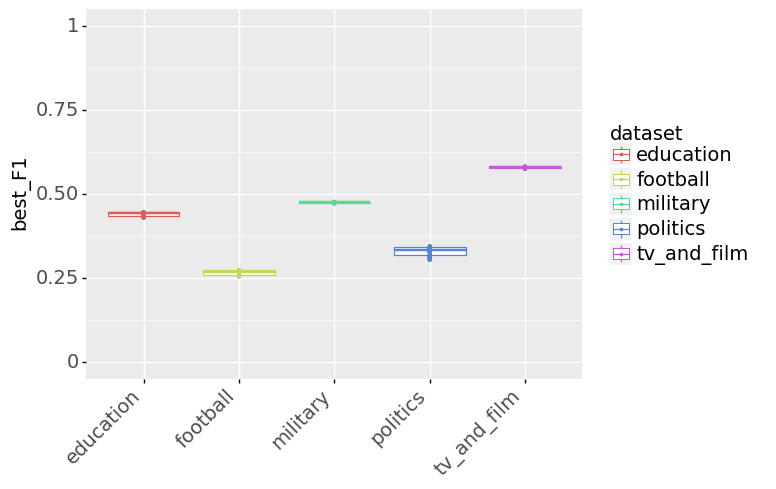

/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/bestTunedF1wikipedia.jpg


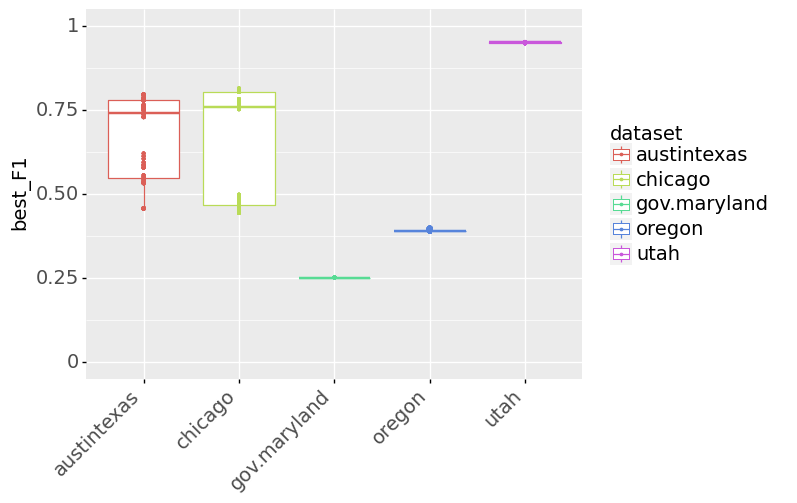

/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/bestTunedF1socrata.jpg


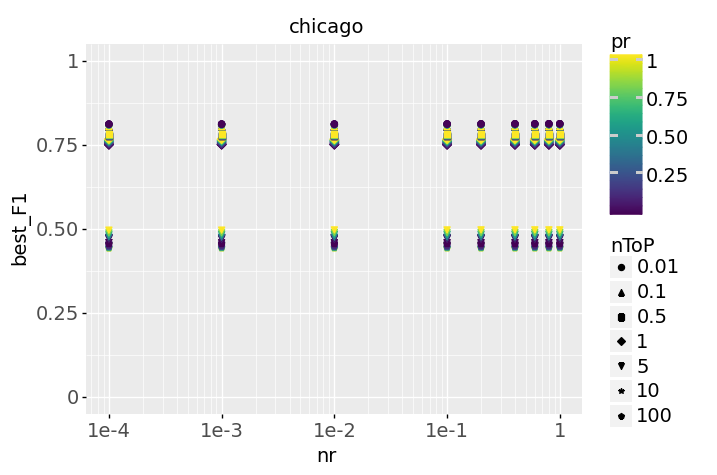

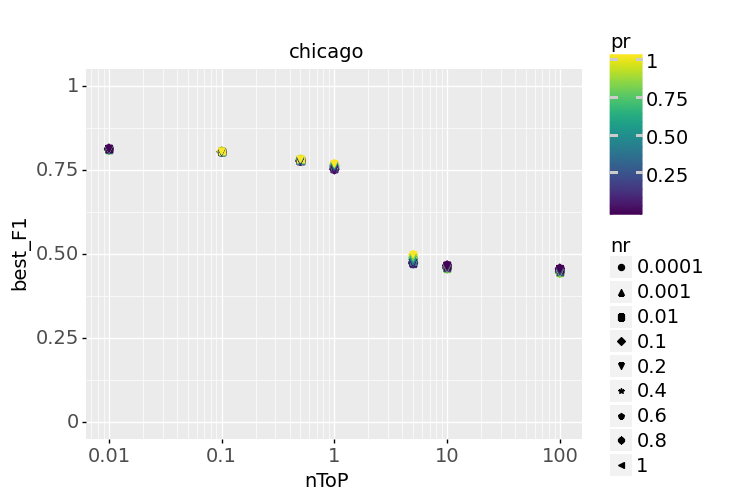

/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/tuningResult_nr_chicago.jpg
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/tuningResult_nToP_chicago.jpg


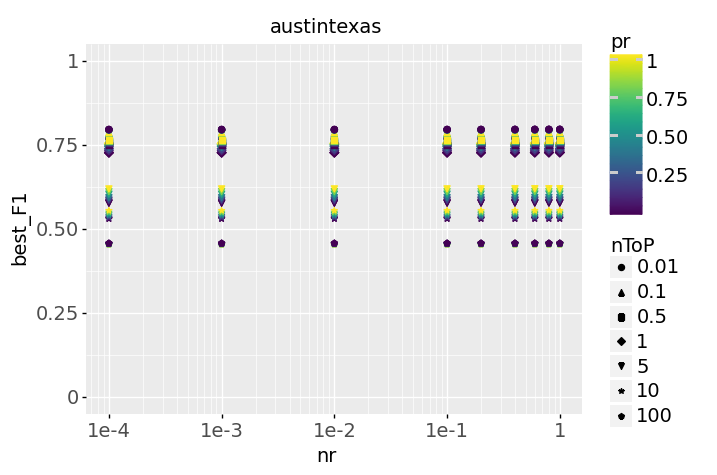

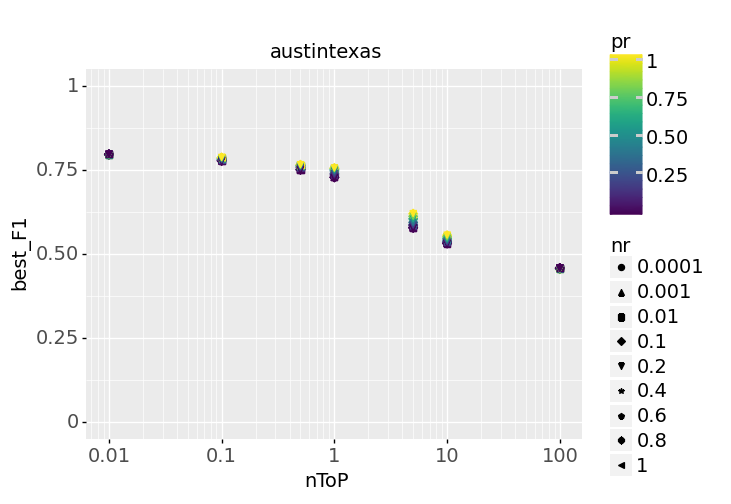

/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/tuningResult_nr_austintexas.jpg
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/tuningResult_nToP_austintexas.jpg


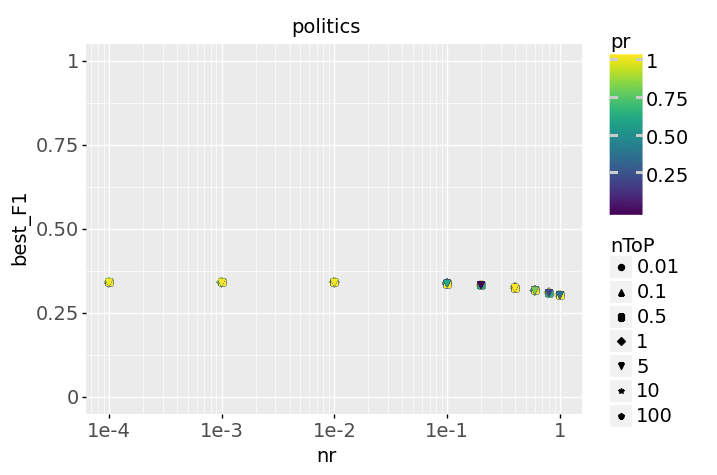

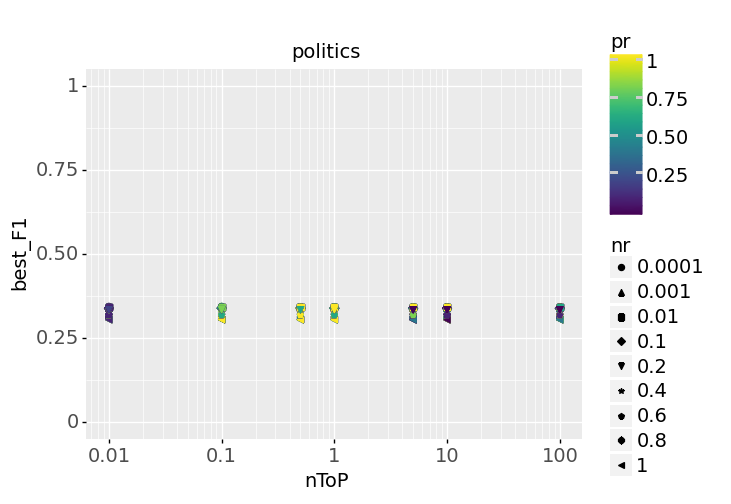

/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/tuningResult_nr_politics.jpg
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/leon/data/dataset_versioning/plotting/plotting/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/tuningResult_nToP_politics.jpg


In [47]:
#print(dfF1[dfF1['dataset']=='politics'])
#TODO: plot something:
dfF1['weakToStrongNegativeWeightRelation']=dfF1['weakNegativeWeight']/dfF1['strongNegativeWeight']
dfF1['weakToStrongPositiveWeightRelation']=dfF1['weakPositiveWeight']/dfF1['strongPositiveWeight']
dfF1['weakToWeakWeightRelation']=dfF1['weakPositiveWeight']/(-dfF1['weakNegativeWeight'])
dfF1['strongToStrongWeightRelation']=dfF1['strongPositiveWeight']/(-dfF1['strongNegativeWeight'])
dfF1['rangeToAvgRange']=dfF1['ThresholdRange']/(-dfF1['ThresholdRangeAvg'])
dfF1['nTOpAsData']=dfF1['nTOp']
dfF1['nrAsData']=dfF1['nr']
dfF1['nToP']=dfF1['nTOpAsData'].astype('category')
dfF1['nr']=dfF1['nrAsData'].astype('category')

dfF1Wikipedia = dfF1[dfF1['dataset'].isin(['politics', 'military', 'football', 'tv_and_film', 'education'])]
dfF1Socrata = dfF1[dfF1['dataset'].isin(['utah', 'chicago', 'austintexas', 'oregon', 'gov.maryland'])]


#plot = (ggplot(df, aes(x='matchingTimePercentage',ymin=0,ymax=1, y='validPercentageFullTimePeriodOfInteresting',group='dataset',color='dataset',shape='dataset')) 
#      + geom_line(size=1.5) 
#      + geom_point(size=3)
#      + scale_x_continuous(name="Matching Time [%]")
#      + scale_y_continuous(name="Validity")
#      + theme(text=element_text(size=14))
#      #+ theme(axis_text_x=element_text(size=12),axis_text_y=element_text(size=12))
#      + labs(title=''))
#    print(plot)
#    fname = 'exportedPlots/validityOverMatchingTime_' + datasource +'.png'
#    plot.save(filename = fname, height=5, width=5, units = 'in', dpi=1000)

def printBoxplot(df,datasource):
    p = (ggplot(df,aes(ymin=0,ymax=1,x='dataset',y='best_F1',color='dataset'))
    + geom_boxplot()
    + geom_point(size=0.5)
    + theme(text=element_text(size=14),axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x="")
    )
    print(p)
    fname = 'exportedPlots/bestTunedF1' + datasource +'.jpg'
    p.save(filename = fname)

printBoxplot(dfF1Wikipedia,"wikipedia")
printBoxplot(dfF1Socrata,"socrata")
#printBoxplot(dfF1) # TODO: in order for this to work we need to get plotnine to first sort by datasource, then by dataset name



datasetNames=dfF1['dataset'].unique()
for dsName in ['chicago','austintexas','politics']:
    curDF = dfF1[dfF1['dataset']==dsName]
    nrPlot = ggplot(curDF, aes(x='nrAsData',ymin=0,ymax=1, y='best_F1',color='pr',shape='nToP')) + scale_x_log10() + geom_point(size=2)  + labs(title = dsName,x="nr") + theme(text=element_text(size=14))
    nTOpPlot = ggplot(curDF, aes(x='nTOpAsData',ymin=0,ymax=1, y='best_F1',color='pr',shape='nr')) + scale_x_log10() + geom_point(size=2)  + labs(title= dsName,x="nToP") + theme(text=element_text(size=14))
    print(nrPlot)
    print(nTOpPlot)
    fname = 'exportedPlots/tuningResult_nr_' + dsName +'.jpg'
    nrPlot.save(filename = fname)
    fname = 'exportedPlots/tuningResult_nToP_' + dsName +'.jpg'
    nTOpPlot.save(filename = fname)
    #
    #print(ggplot(curDF, aes(x='pr',ymin=0,ymax=1, y='best_F1',color='nr',alpha='nTOp')) + scale_x_log10() + geom_point()  + labs(title=dsName))
    #print(ggplot(curDF, aes(x='ThresholdRange',ymin=0,ymax=1, y='best_F1',color='nTOp')) + scale_x_log10() + geom_point()  + labs(title=dsName))
    #print(ggplot(curDF, aes(x='ThresholdRange',ymin=0,ymax=1, y='best_F1',color='nr')) + scale_x_log10() + geom_point()  + labs(title=dsName))